In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv
/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset_info.txt
/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


In [2]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
msgs = [
    'invalid value encountered in greater',
    'invalid value encountered in less'
]
for msg in msgs:
    warnings.filterwarnings('ignore', category=RuntimeWarning, message=msg)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from itertools import combinations

## 🎯 **Evaluation Metric Explained: RMSE**

To evaluate our predictions, we use **Root Mean Squared Error (RMSE)**, a measure of how accurate our model's predictions are.

In simpler terms, RMSE represents **how far off, on average, our predicted listening times are from the actual values**. A lower RMSE means the model predicts more accurately.

Mathematically, RMSE is calculated as follows:

$$
\text{RMSE} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y}_i)^2}
$$

Where:

- \(y_i\) is the **actual** listening time.
- \(\hat{y}_i\) is the **predicted** listening time from our model.
- \(N\) is the total number of predictions.

**Our goal**: Reduce the RMSE as much as possible, resulting in the best-performing model.


---

## 📊 Exploratory Data Analysis (EDA)

EDA is crucial for understanding the data before modeling. Through careful analysis, we identify patterns, distributions, relationships between features, and data quality issues.

**Goal of the competition**: Predict podcast listening time.


---


### Data Loading

We load two separate training datasets (`train1_df`, `train2_df`) and a test dataset (`test_df`). Combining multiple training sources increases the amount and diversity of available data, potentially improving model performance and generalization.


In [3]:
train1_df = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
train2_df = pd.read_csv('/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')

### Removing duplicates and merging datasets

We identify and remove duplicate rows from each training dataset (`train1_df`, `train2_df`) to ensure data quality. The cleaned datasets are then concatenated into a single DataFrame (`train_df`).

In [4]:
# Count duplicates in each
n_duplicates_1 = train1_df.duplicated().sum()
n_duplicates_2 = train2_df.duplicated().sum()

print(f"\nNumber of duplicates in train1_df: {n_duplicates_1}")
print(f"\nNumber of duplicates in train2_df: {n_duplicates_2}")

# Drop duplicates
train1_df = train1_df.drop_duplicates()
train2_df = train2_df.drop_duplicates()

# Concatenate the cleaned datasets
train_df = pd.concat([train1_df, train2_df], ignore_index=True)

# Final check
print(f"\nFinal dataset shape: {train_df.shape}")
train_df.info()


Number of duplicates in train1_df: 0

Number of duplicates in train2_df: 2500

Final dataset shape: (800000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  float64
 1   Podcast_Name                 800000 non-null  object 
 2   Episode_Title                800000 non-null  object 
 3   Episode_Length_minutes       707882 non-null  float64
 4   Genre                        800000 non-null  object 
 5   Host_Popularity_percentage   800000 non-null  float64
 6   Publication_Day              800000 non-null  object 
 7   Publication_Time             800000 non-null  object 
 8   Guest_Popularity_percentage  648984 non-null  float64
 9   Number_of_Ads                799999 non-null  float64
 10  Episode_Sentiment            800000 non-null  object 
 11  Lis

### Defining columns and initial exploration

- Store test IDs for submission.
- Define the target column: `Listening_Time_minutes`.
- Automatically detect and separate categorical and numerical columns.
- Display column lists for a clear initial overview.


In [5]:
# Save 'id' column for submission
test_ids = test_df['id']

# Define the target column
target_column = 'Listening_Time_minutes'

# Select categorical and numerical columns (initial)
categorical_columns = train_df.select_dtypes(include=['object']).columns
numerical_columns = train_df.select_dtypes(exclude=['object']).columns
numerical_columns = [col for col in numerical_columns if col != 'id']

# Print out column information
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns)
print("\nNumerical Columns:", numerical_columns)

Target Column: Listening_Time_minutes

Categorical Columns: Index(['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day',
       'Publication_Time', 'Episode_Sentiment'],
      dtype='object')

Numerical Columns: ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']


### Quick Data Overview

Show the first five rows of the combined training dataset (`train_df`) for an initial qualitative check of the data structure and content.


In [6]:
train_df.head(5)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0.0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1.0,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2.0,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3.0,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4.0,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


### Statistical Summary

Generate descriptive statistics for numerical features in `train_df` to quickly assess distributions, ranges, and detect potential anomalies or outliers.


In [7]:
train_df.round(2).describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,707882.000000,800000.000000,648984.000000,799999.000000,794868.000000
mean,374999.500000,64.399933,59.878370,52.086840,1.358224,45.443272
std,216506.495284,32.982345,22.890414,28.485915,1.149614,27.138473
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.670000,39.450000,28.090000,0.000000,23.180000
50%,374999.500000,63.760000,60.060000,53.330000,1.000000,43.390000
75%,562499.250000,93.990000,79.560000,76.482500,2.000000,64.810000
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


### Missing Values Visualization

Create a heatmap to visually identify missing values across features in `train_df`. Darker colors indicate missing data, helping to quickly pinpoint problematic areas.


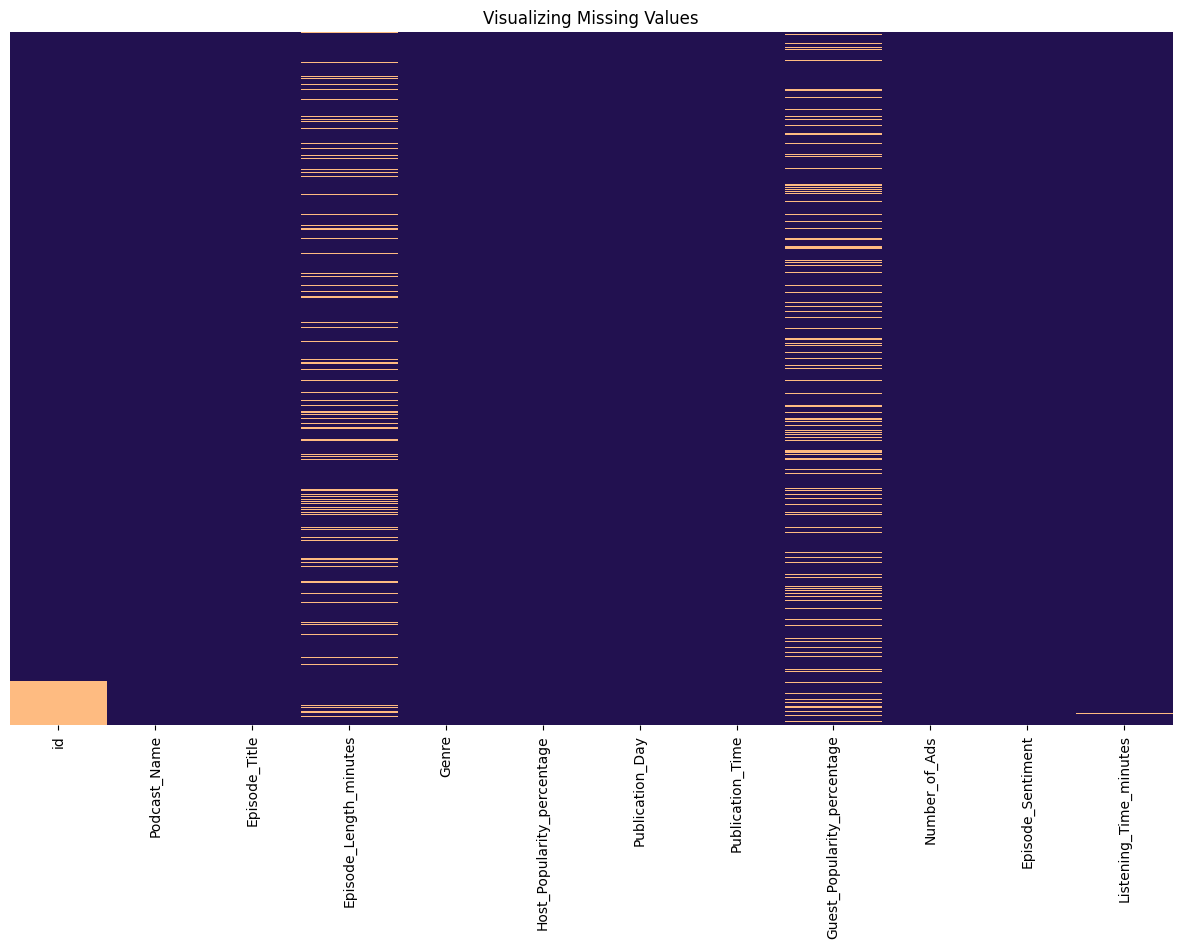

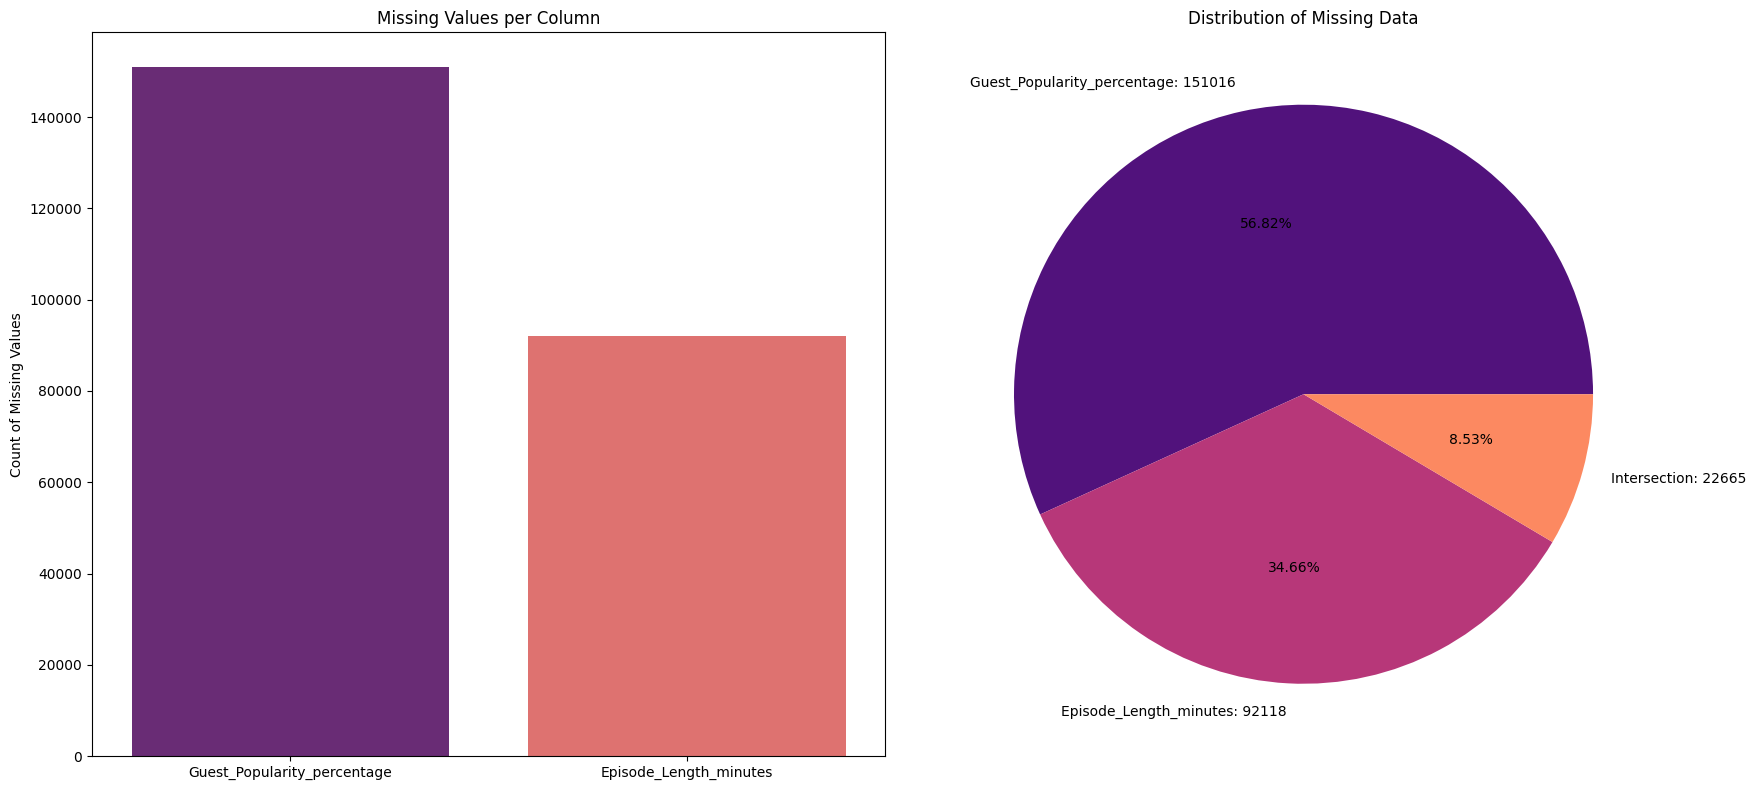

Total missing values in Guest_Popularity_percentage: 151016, 18.88% of the training set.
Total missing values in Episode_Length_minutes: 92118, 11.51% of the training set.
Total intersection count of missing values: 22665
Intersection represents 2.83% of the training set.


In [8]:
# Heatmap of missing values
plt.figure(figsize=(15, 9))
plt.title("Visualizing Missing Values")
sns.heatmap(train_df.isnull(), cbar=False, cmap=sns.color_palette('magma'), yticklabels=False)
plt.show()

# Step 1: Count missing values by column
missing_data = train_df.isnull().sum()

# Step 2: Get the two columns with the largest number of missing values
top_missing = missing_data.sort_values(ascending=False).head(2)
col1, col2 = top_missing.index

# Step 3: Calculate the missing values stats
missing_col1 = missing_data[col1]
missing_col2 = missing_data[col2]

# Percentage missing in each column
percent_missing_col1 = (missing_col1 / len(train_df)) * 100
percent_missing_col2 = (missing_col2 / len(train_df)) * 100

# Calculate the intersection of missing values
intersection = train_df[col1].isnull() & train_df[col2].isnull()
intersection_count = intersection.sum()

# Percent of total missing values that the intersection represents
intersection_percent = (intersection_count / len(train_df)) * 100

# Step 4: Plot the stats for both columns and their intersection
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left plot: barplot of missing values per column
sns.barplot(x=top_missing.index, y=top_missing.values, ax=axes[0], palette='magma')
axes[0].set_title('Missing Values per Column')
axes[0].set_ylabel('Count of Missing Values')

# Right plot: pie chart of the intersection and individual missing values
labels = [
    f'{col1}: {missing_col1}',
    f'{col2}: {missing_col2}',
    f'Intersection: {intersection_count}'
]
sizes = [missing_col1, missing_col2, intersection_count]
axes[1].pie(sizes, labels=labels, autopct='%1.2f%%', colors=sns.color_palette('magma', 3))
axes[1].set_title('Distribution of Missing Data')

plt.tight_layout()
plt.show()

# Additional details
print(f"Total missing values in {col1}: {missing_col1}, {percent_missing_col1:.2f}% of the training set.")
print(f"Total missing values in {col2}: {missing_col2}, {percent_missing_col2:.2f}% of the training set.")
print(f"Total intersection count of missing values: {intersection_count}")
print(f"Intersection represents {intersection_percent:.2f}% of the training set.")


### Boxplots and Violin Plots for Numerical Features

Visualize each numerical feature using:

- **Boxplots** (top) to detect outliers and show central tendencies clearly.
- **Violin plots** (bottom) to depict the distribution shapes, with annotated means (blue) and medians (red) for deeper insight.


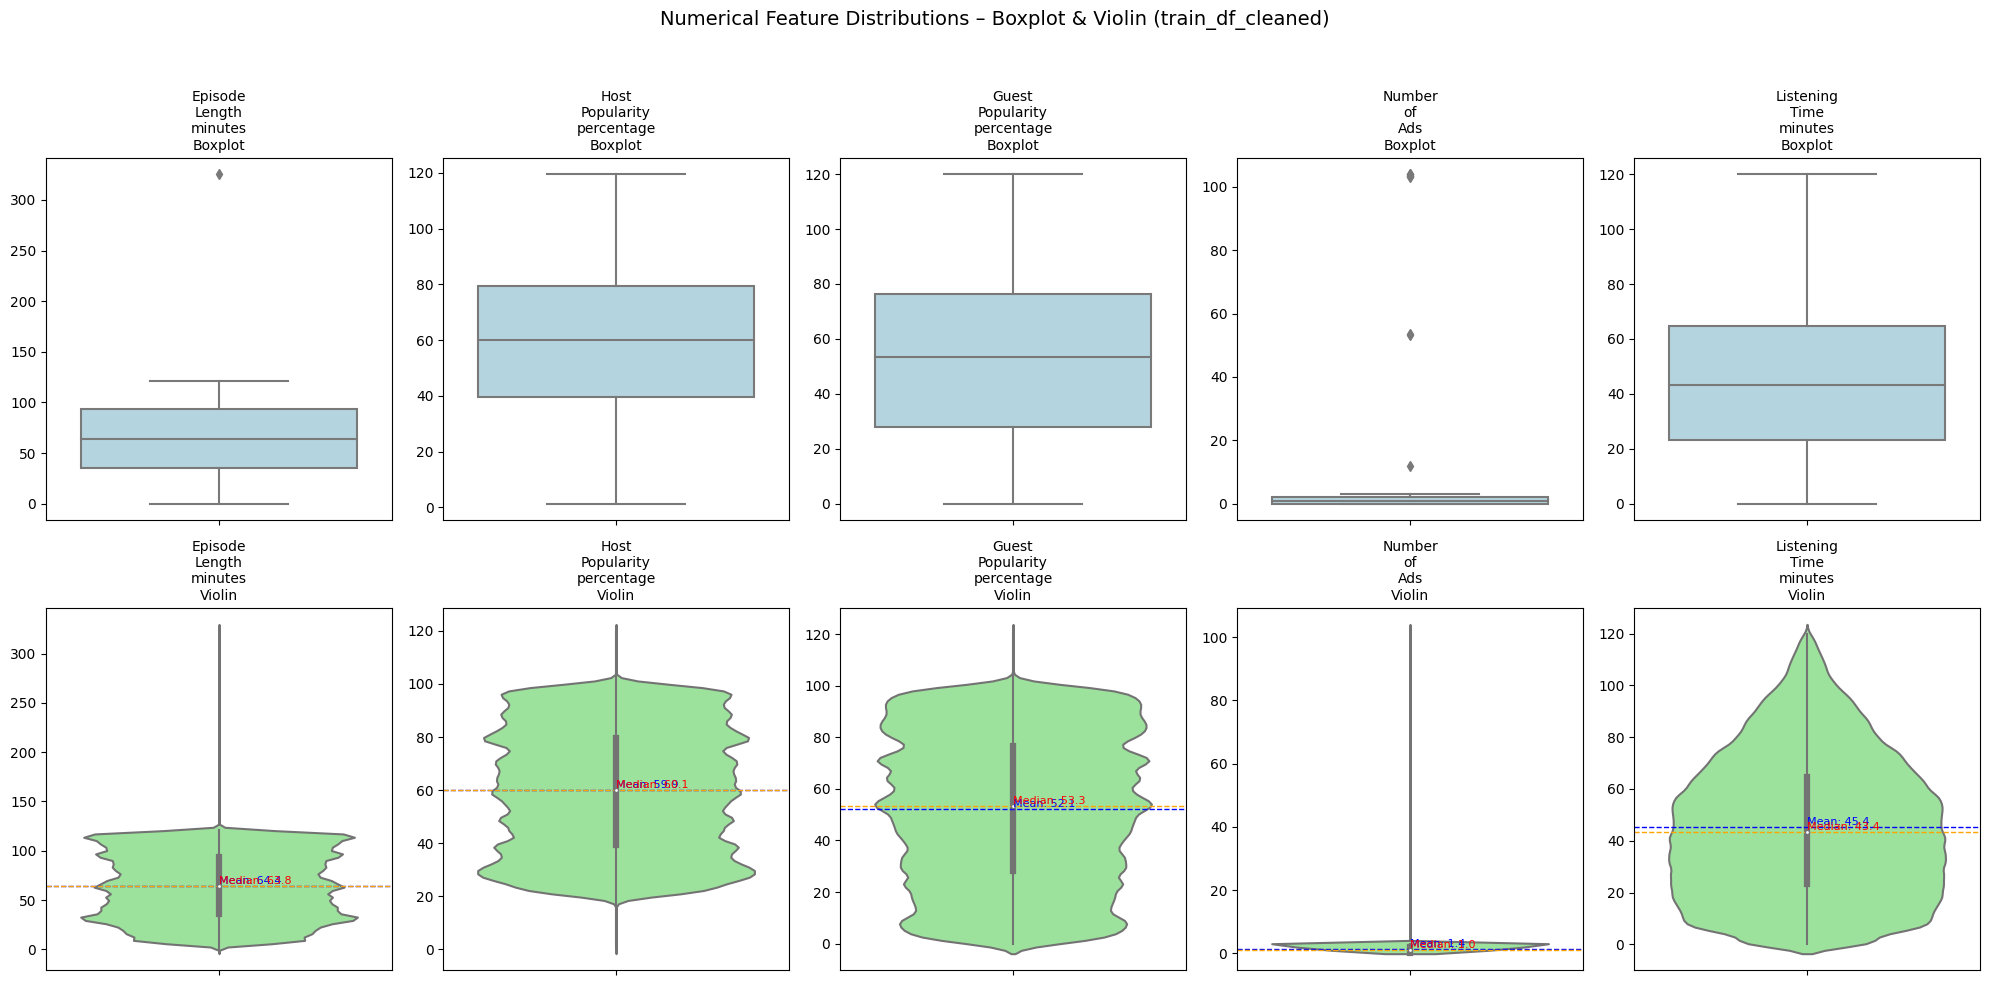

In [9]:
# Création des sous-graphiques : boxplots en haut, violins en bas
fig, axes = plt.subplots(nrows=2, ncols=len(numerical_columns), figsize=(4 * len(numerical_columns), 10), sharey=False)

for i, feature in enumerate(numerical_columns):
    # Préparer le label en remplaçant les underscores par des sauts de ligne
    feature_label = feature.replace('_', '\n')
    
    # Boxplot en haut
    sns.boxplot(y=train_df[feature], ax=axes[0, i], color='lightblue')
    axes[0, i].set_title(f"{feature_label}\nBoxplot", fontsize=10)
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('')
    
    # Violin plot en bas avec la boîte interne
    sns.violinplot(y=train_df[feature], ax=axes[1, i], inner='box', color='lightgreen')
    
    # Calcul des statistiques
    mean_val = train_df[feature].mean()
    median_val = train_df[feature].median()
    
    # Annotation de la moyenne
    axes[1, i].axhline(mean_val, color='blue', linestyle='--', linewidth=1)
    axes[1, i].text(0, mean_val, f"Mean: {mean_val:.1f}", color='blue', fontsize=8, va='bottom')
    
    # Annotation de la médiane
    axes[1, i].axhline(median_val, color='orange', linestyle='--', linewidth=1)
    axes[1, i].text(0, median_val, f"Median: {median_val:.1f}", color='red', fontsize=8, va='bottom')
    
    axes[1, i].set_title(f"{feature_label}\nViolin", fontsize=10)
    axes[1, i].set_xlabel('')
    axes[1, i].set_ylabel('')

fig.suptitle('Numerical Feature Distributions – Boxplot & Violin (train_df_cleaned)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Counting and Visualizing Outliers

We compute the number of outliers per numerical feature using the IQR method, then visualize these counts with a barplot. This step identifies problematic variables with potential data quality issues.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


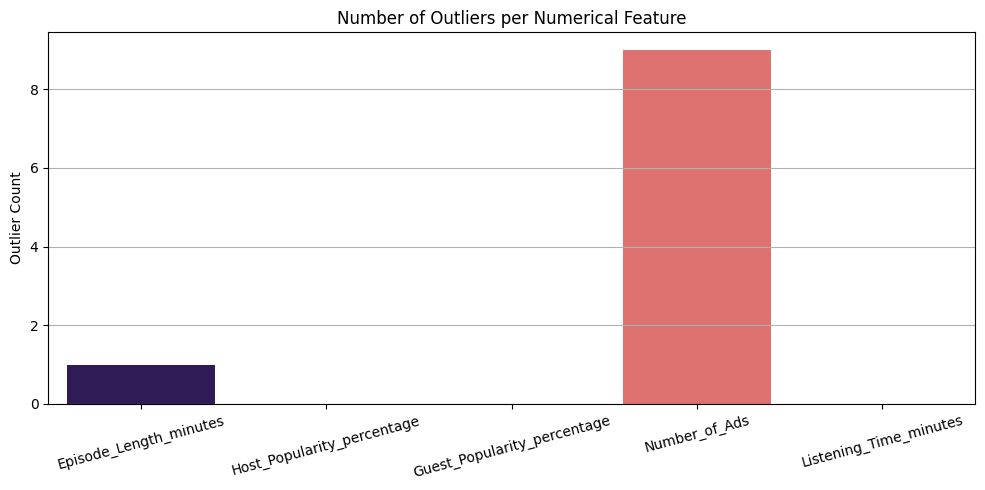

In [10]:
# Compute outliers using IQR method
outlier_counts = {}

for feature in numerical_columns:
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
    outlier_counts[feature] = outliers.shape[0]

# Plot the number of outliers
plt.figure(figsize=(10, 5))
sns.barplot(x=list(outlier_counts.keys()), y=list(outlier_counts.values()), palette='magma')
plt.title("Number of Outliers per Numerical Feature")
plt.ylabel("Outlier Count")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Contextual Outlier Replacement

We create a cleaned copy (`train_df_cleaned`) of the original dataset by replacing each outlier with the median value of its corresponding `Podcast_Name` group. If the group median isn't available, we fallback to the global median. This preserves context-specific data relationships.


In [11]:
# Make a copy of the dataset
train_df_cleaned = train_df.copy()

for feature in numerical_columns:
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Boolean mask of outliers
    is_outlier = (train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)

    for idx in train_df[is_outlier].index:
        podcast = train_df.loc[idx, 'Podcast_Name']

        # Median of the group (excluding outliers)
        group_values = train_df[(train_df['Podcast_Name'] == podcast) & ~is_outlier][feature]
        if not group_values.empty:
            replacement = group_values.median()
        else:
            replacement = train_df[~is_outlier][feature].median()

        train_df_cleaned.at[idx, feature] = replacement

### Post-cleaning Distribution Check (Boxplots & Violin Plots)

To verify the effectiveness of our outlier treatment, we visualize each numerical feature post-cleaning:

- **Boxplots** (top): Identify residual outliers and overall data dispersion.
- **Violin plots** (bottom): Illustrate data distribution with mean (blue) and median (red) clearly annotated.


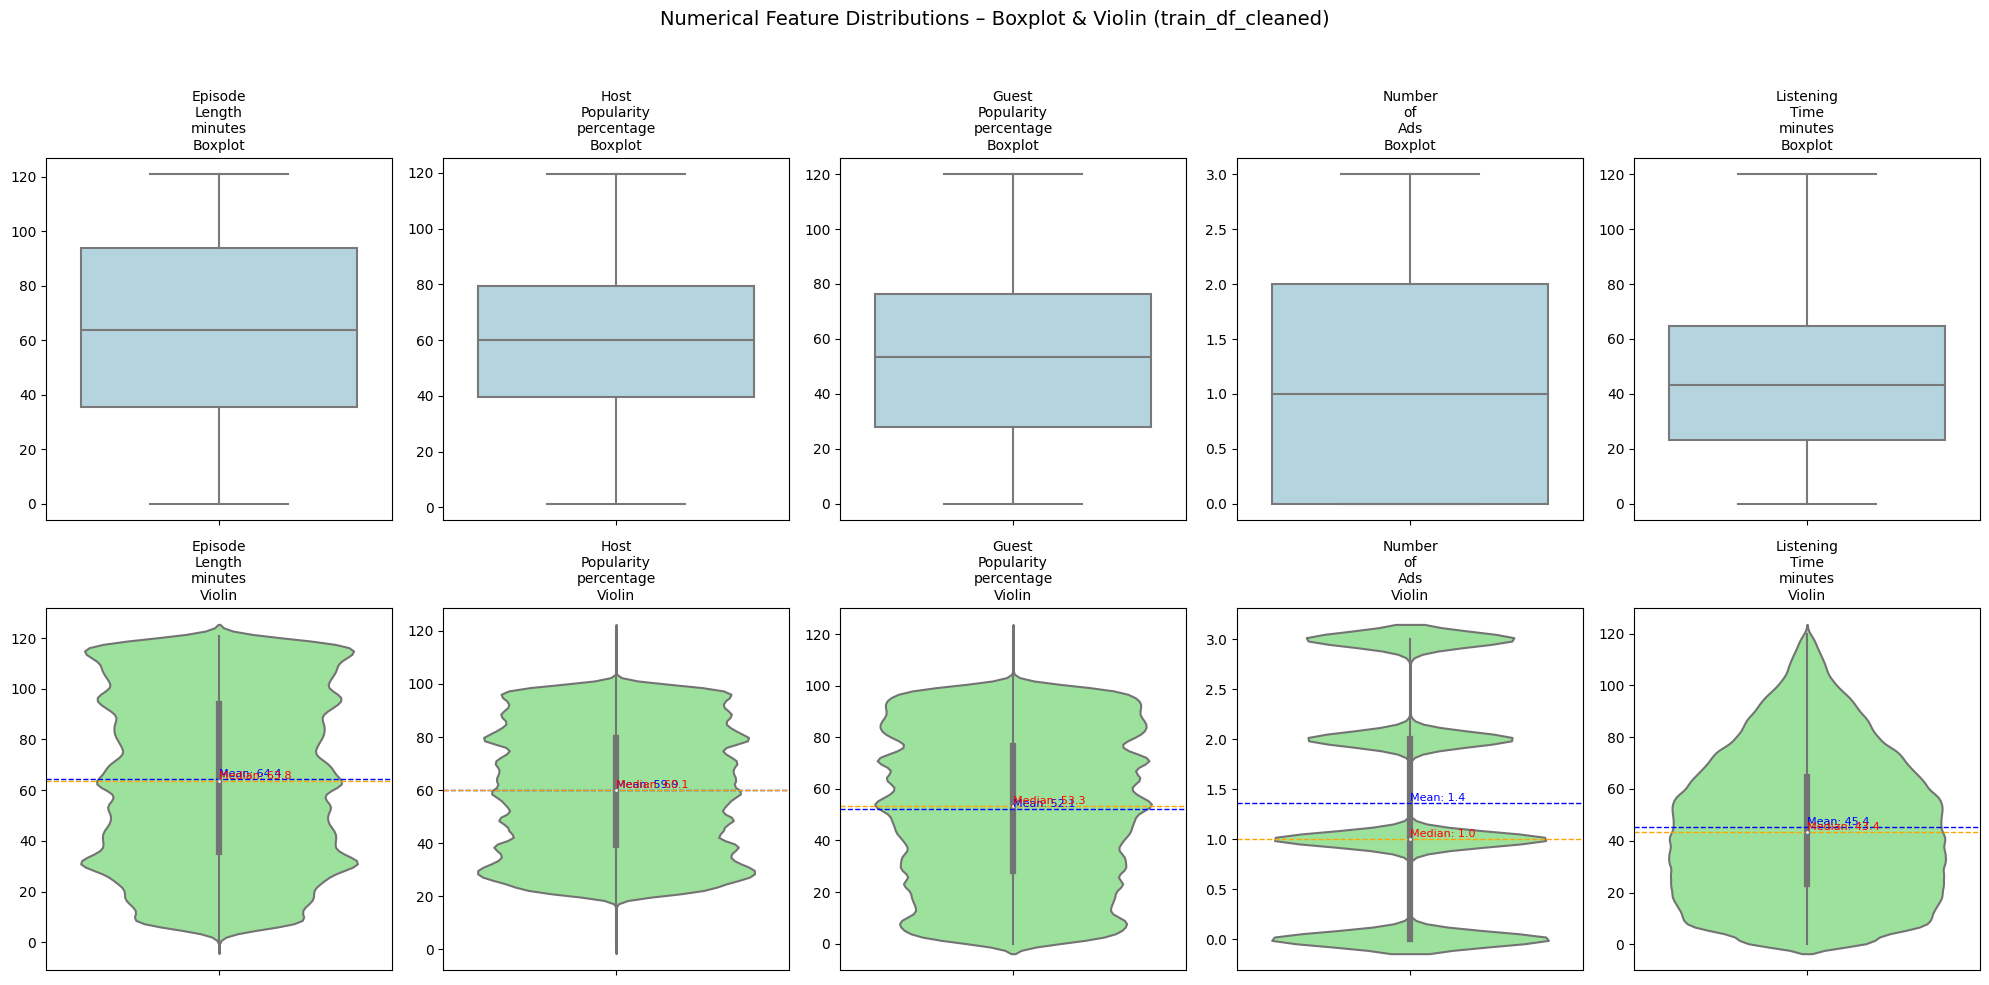

In [12]:
# Création des sous-graphes : boxplots en haut, violins en bas
fig, axes = plt.subplots(nrows=2, ncols=len(numerical_columns), figsize=(4 * len(numerical_columns), 10), sharey=False)

for i, feature in enumerate(numerical_columns):
    feature_label = feature.replace('_', '\n')

    # Boxplot en haut
    sns.boxplot(y=train_df_cleaned[feature], ax=axes[0, i], color='lightblue')
    axes[0, i].set_title(f"{feature_label}\nBoxplot", fontsize=10)
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('')

    # Violin plot en bas avec moyenne et médiane
    sns.violinplot(y=train_df_cleaned[feature], ax=axes[1, i], inner='box', color='lightgreen')
    
    mean_val = train_df_cleaned[feature].mean()
    median_val = train_df_cleaned[feature].median()
    
    axes[1, i].axhline(mean_val, color='blue', linestyle='--', linewidth=1)
    axes[1, i].text(0, mean_val, f"Mean: {mean_val:.1f}", color='blue', fontsize=8, va='bottom')
    
    axes[1, i].axhline(median_val, color='orange', linestyle='--', linewidth=1)
    axes[1, i].text(0, median_val, f"Median: {median_val:.1f}", color='red', fontsize=8, va='bottom')
    
    axes[1, i].set_title(f"{feature_label}\nViolin", fontsize=10)
    axes[1, i].set_xlabel('')
    axes[1, i].set_ylabel('')

fig.suptitle('Numerical Feature Distributions – Boxplot & Violin (train_df_cleaned)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Analyzing Categorical Features

For each categorical feature, we visualize:

- **Left**: Barplots showing the distribution of categories (ordered by increasing frequency).
- **Right**: Boxplots illustrating the relationship between categories and the target (`Listening_Time_minutes`).  
This provides insights into how each category influences the target variable.


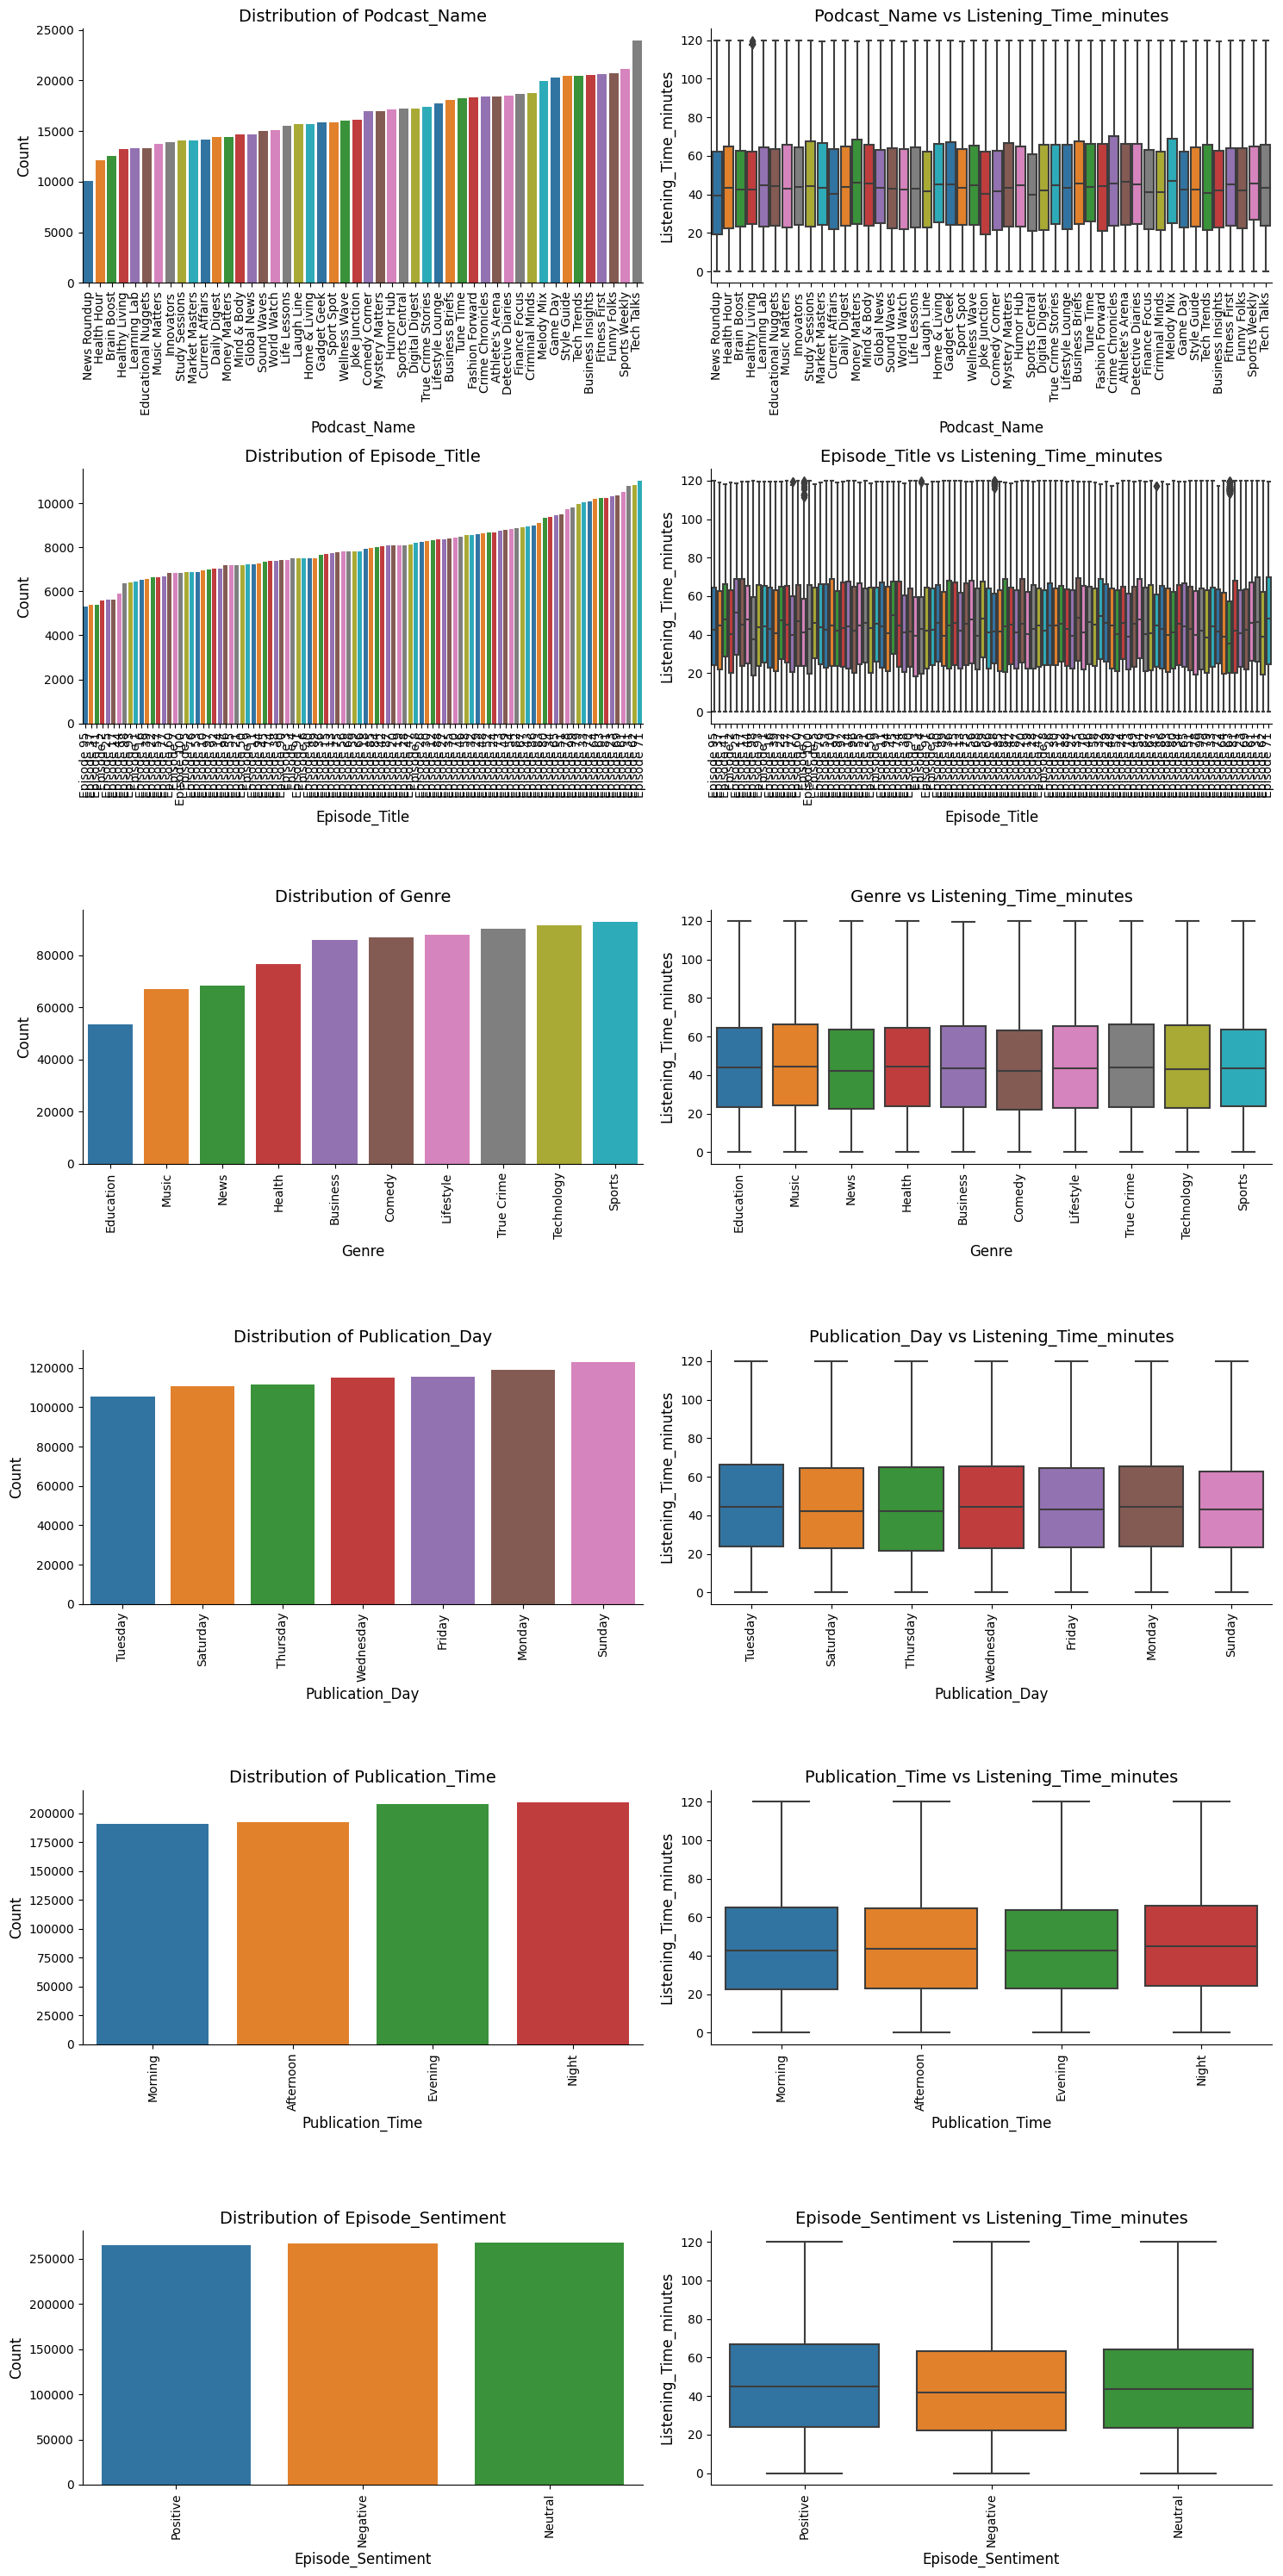

In [13]:
# Création des sous-graphiques pour chaque variable catégorielle
fig, axes = plt.subplots(len(categorical_columns), 2, figsize=(15, 5 * len(categorical_columns)))

for i, column in enumerate(categorical_columns):
    # Ordre croissant des catégories selon la fréquence
    order = train_df_cleaned[column].value_counts(ascending=True).index

    # Barplot (gauche)
    sns.countplot(data=train_df_cleaned, x=column, ax=axes[i, 0], order=order, palette='tab10')
    axes[i, 0].set_title(f'Distribution of {column}', fontsize=14)
    axes[i, 0].set_xlabel(column, fontsize=12)
    axes[i, 0].set_ylabel('Count', fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=90)
    sns.despine(ax=axes[i, 0])

    # Boxplot (droite)
    sns.boxplot(data=train_df_cleaned, x=column, y=target_column, ax=axes[i, 1], order=order, palette='tab10')
    axes[i, 1].set_title(f'{column} vs {target_column}', fontsize=14)
    axes[i, 1].set_xlabel(column, fontsize=12)
    axes[i, 1].set_ylabel(target_column, fontsize=12)
    axes[i, 1].tick_params(axis='x', rotation=90)
    sns.despine(ax=axes[i, 1])

plt.tight_layout()
plt.show()

### Extracting Episode Numbers

The numerical episode identifier is extracted from the `Episode_Title` feature (e.g., "Episode 95") and converted into a numerical feature (`Episode_Number`). This helps to utilize episode sequencing as a potential predictor.


In [14]:
# Extraire le nombre de la colonne 'Episode_Title' et le convertir en int
train_df_cleaned['Episode_Number'] = train_df_cleaned['Episode_Title'].str.extract('(\d+)').astype(int)
train_df_cleaned = train_df_cleaned.drop(['id'], axis=1)

### Cyclical Feature Encoding

To preserve the cyclical nature of days and times, we map:

- `Publication_Day`: Monday=0 to Sunday=6
- `Publication_Time`: Morning=9, Afternoon=14, Evening=19, Night=23  
- `Episode_Sentiment`: Negative=1, Neutral=2, Positive=3

Then we apply cyclical encoding (sine/cosine) to transform these variables into numerical features effectively capturing their cyclical patterns.

In [15]:
# Mapping initial des catégories
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
               'Friday': 4, 'Saturday': 5, 'Sunday': 6}

time_mapping = {'Morning': 9, 'Afternoon': 14, 'Evening': 19, 'Night': 23}

sentiment_mapping = {'Negative': 1, 'Neutral': 2, 'Positive': 3}

# Encodage numérique initial
train_df_cleaned['Publication_Day_num'] = train_df_cleaned['Publication_Day'].map(day_mapping)
train_df_cleaned['Publication_Time_num'] = train_df_cleaned['Publication_Time'].map(time_mapping)
train_df_cleaned['Episode_Sentiment_num'] = train_df_cleaned['Episode_Sentiment'].map(sentiment_mapping)

# Encodage cyclique (jour sur 7, heure sur 24, sentiment sur 3)
train_df_cleaned['Publication_Day_sin'] = np.sin(2 * np.pi * train_df_cleaned['Publication_Day_num'] / 7)
train_df_cleaned['Publication_Day_cos'] = np.cos(2 * np.pi * train_df_cleaned['Publication_Day_num'] / 7)

train_df_cleaned['Publication_Time_sin'] = np.sin(2 * np.pi * train_df_cleaned['Publication_Time_num'] / 24)
train_df_cleaned['Publication_Time_cos'] = np.cos(2 * np.pi * train_df_cleaned['Publication_Time_num'] / 24)

### Target Encoding for High-Cardinality Variables

`Podcast_Name` and `Genre`, having many unique categories, are encoded using target encoding with cross-validation to mitigate overfitting. Missing categories are filled with the `Host_Popularity_percentage` mean to ensure consistency.

In [16]:
# Liste des colonnes catégorielles à encoder
categorical_columns = ['Podcast_Name', 'Genre']

# Boucle sur chaque colonne
for col in categorical_columns:
    # Initialiser la nouvelle colonne d'encodage cible
    train_df_cleaned[f'{col}_TE'] = np.nan

    # Configuration de la validation croisée
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(train_df_cleaned):
        # Calculer la moyenne de la cible pour chaque modalité sur l'ensemble d'entraînement
        means = train_df_cleaned.iloc[train_idx].groupby(col)['Host_Popularity_percentage'].mean()
        # Appliquer ces moyennes sur la partie validation
        train_df_cleaned.loc[train_df_cleaned.index[val_idx], f'{col}_TE'] = train_df_cleaned.iloc[val_idx][col].map(means)

    # Remplacer les valeurs manquantes (modalités non rencontrées) par la moyenne globale de la cible
    global_mean = train_df_cleaned['Host_Popularity_percentage'].mean()
    train_df_cleaned[f'{col}_TE'] = train_df_cleaned[f'{col}_TE'].fillna(global_mean)

### Dropping Intermediate and Original Categorical Columns

After feature engineering, we remove intermediate numerical encoding columns and the original categorical variables (`Podcast_Name`, `Genre`, `Episode_Title`) to retain only relevant, fully encoded numerical features. We also update the categorical and numerical column lists accordingly.


In [17]:
# Suppression des colonnes intermédiaires
train_df_cleaned = train_df_cleaned.drop(['Publication_Day_num', 'Publication_Time_num', 'Episode_Sentiment_num','Podcast_Name','Genre','Episode_Title'], axis=1)

# Update categorical and numerical columns (initial)
categorical_columns = train_df_cleaned.select_dtypes(include=['object']).columns
numerical_columns = train_df_cleaned.select_dtypes(exclude=['object']).columns

### Correlation Matrix Visualization

Finally, we calculate and visualize the correlation matrix for numerical features to identify strong relationships and potential multicollinearity, assisting feature selection for modeling.


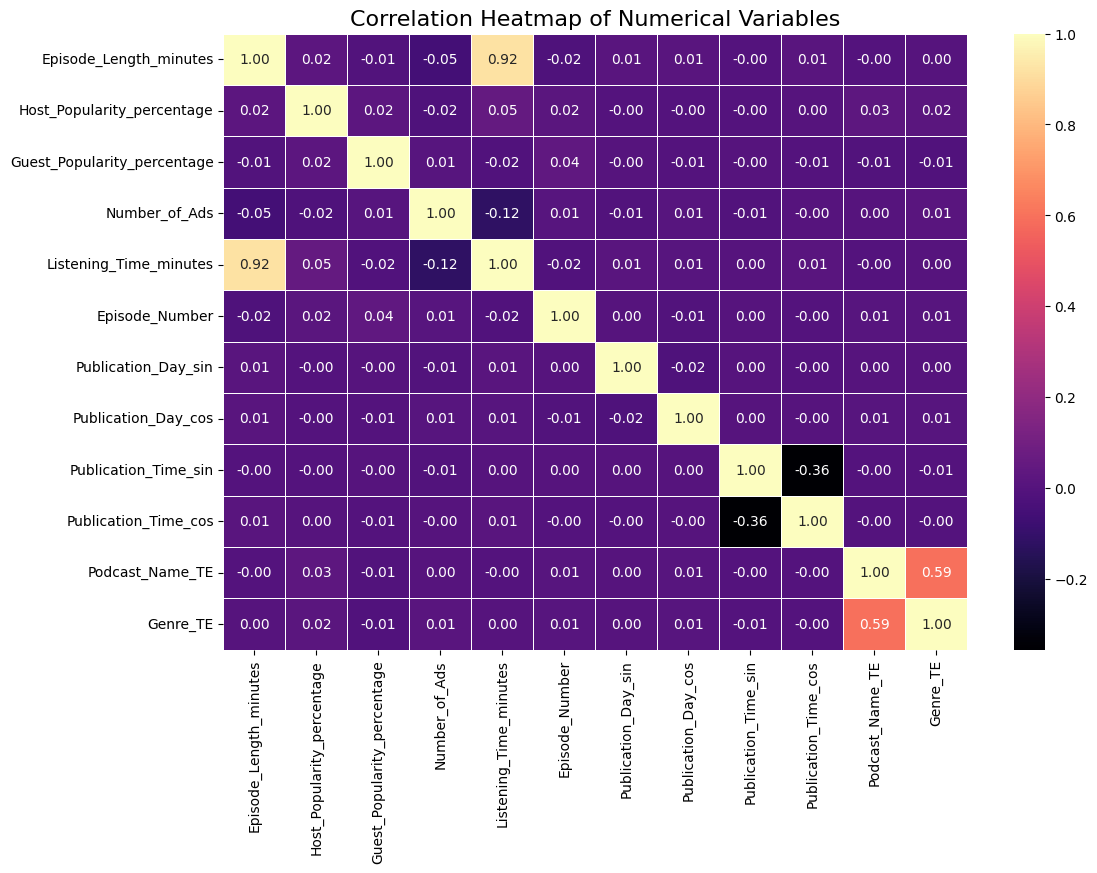

In [18]:
# Calculate the correlation matrix
correlation_matrix = train_df_cleaned[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="magma", cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables", fontsize=16)
plt.show()

### Principal Component Analysis (PCA)

We apply PCA to numerical features after imputing missing values with the median and standardizing the data. PCA reduces dimensionality, helps visualize patterns, and uncovers correlations among features.

- **Step 1**: Median imputation and standardization of numerical data.
- **Step 2**: PCA reduces the features to two principal components (`PC1`, `PC2`) for visualization.


In [19]:
# Copier les données nettoyées pour l'EDA
df_eda = train_df_cleaned.copy()
cols_to_use = [col for col in numerical_columns if col not in [target_column]]

# Sélectionner les colonnes numériques à utiliser
X_eda = df_eda[cols_to_use]

# Imputer les valeurs manquantes avec la médiane en utilisant sklearn
imputer = SimpleImputer(strategy='median')
X_eda_imputed = imputer.fit_transform(X_eda)

# Standardiser les features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eda_imputed)

# PCA sur 2 composantes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Insérer les résultats de la PCA dans df_eda
df_eda["PC1"] = X_pca[:, 0]
df_eda["PC2"] = X_pca[:, 1]

### PCA Correlation Circle

The PCA correlation circle visualizes the relationship between the original numerical features and the principal components:

- Arrows represent original features.
- The closer a feature is to the circle boundary, the better it is represented by the two principal components.
- The angle between arrows indicates feature correlations (small angles = high correlation).
- PC1 and PC2 axis labels show the percentage of variance explained.

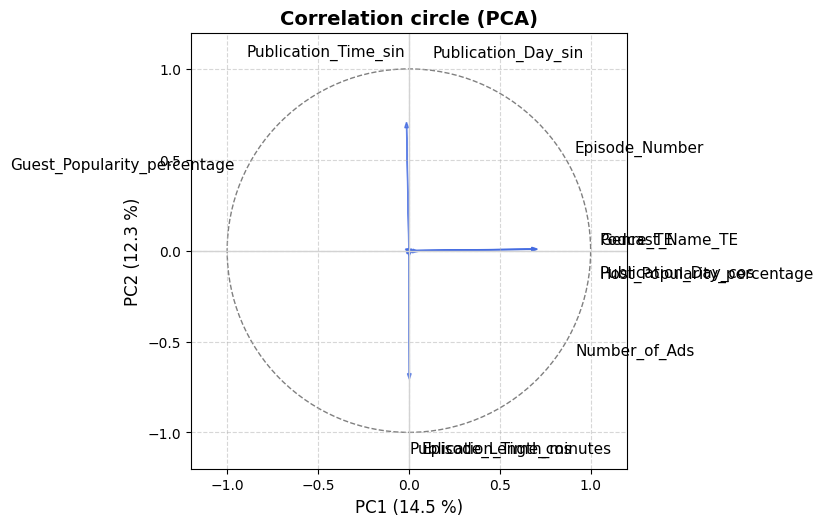

In [20]:
# Retrieve from previous PCA
components = pca.components_
explained_var = pca.explained_variance_ratio_
feature_names = cols_to_use

# Plot
plt.figure(figsize=(8, 8))
plt.axhline(0, color='lightgray', linewidth=1)
plt.axvline(0, color='lightgray', linewidth=1)

# Unit circle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1)
plt.gca().add_artist(circle)

# Arrows and angle-based label positioning
for i, var in enumerate(feature_names):
    x, y = components[0, i], components[1, i]

    # Draw arrow
    plt.arrow(0, 0, x, y, color='royalblue', alpha=0.8, head_width=0.02, length_includes_head=True)

    # Compute angle to spread labels naturally
    angle = np.arctan2(y, x)
    radius = 1.05  # label distance

    label_x = radius * np.cos(angle)
    label_y = radius * np.sin(angle)

    align_h = 'left' if label_x > 0 else 'right'
    align_v = 'bottom' if label_y > 0 else 'top'

    plt.text(label_x, label_y, var, fontsize=11, ha=align_h, va=align_v)

# Layout
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f} %)", fontsize=12)
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f} %)", fontsize=12)
plt.title("Correlation circle (PCA)", fontsize=14, weight='bold')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:
"""
# On récupère dynamiquement toutes les colonnes numériques
final_numerical_columns = train_df_cleaned.select_dtypes(include='number').columns

# On filtre le dataframe pour ne garder que les colonnes numériques
train_df_cleaned = train_df_cleaned[final_numerical_columns]

# Variables numériques cibles
target_variables = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Number_of_Ads']

# Boucle sur chaque paire de colonnes
for col1, col2 in combinations(final_numerical_columns, 2):
    for target in target_variables:
        # Sécurité : ne pas encoder la variable sur elle-même
        if target in [col1, col2]:
            continue

        # Calcul des stats groupées
        group_stats = train_df_cleaned.groupby([col1, col2])[target].agg(['mean', 'std']).reset_index()
        group_stats.columns = [col1, col2, f'{col1}_{col2}_{target}_mean', f'{col1}_{col2}_{target}_std']

        # Merge avec le dataframe d'origine
        train_df_cleaned = train_df_cleaned.merge(group_stats, on=[col1, col2], how='left')

        # Calcul de la différence entre la valeur réelle et la moyenne
        train_df_cleaned[f'{col1}_{col2}_{target}_meandiff'] = (
            train_df_cleaned[target] - train_df_cleaned[f'{col1}_{col2}_{target}_mean']
        )

        # Produit des encodages cibles si dispo
        col1_te = f'{col1}_TE'
        col2_te = f'{col2}_TE'
        if col1_te in train_df_cleaned.columns and col2_te in train_df_cleaned.columns:
            train_df_cleaned[f'{col1}_{col2}_{target}_meanproduct'] = (
                train_df_cleaned[col1_te] * train_df_cleaned[col2_te]
            )


# Define features and target from cleaned dataset
X = train_df_cleaned.drop(columns=[target_column])
y = train_df_cleaned[target_column]

# Clean y before train/val split
mask = y.notnull() & np.isfinite(y)
X = X[mask]
y = y[mask]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize XGBoost regressor with GPU acceleration
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    tree_method='gpu_hist'
)

# Train the model
xgb_reg.fit(X_train, y_train)

# Predict and evaluate on validation set
y_pred = xgb_reg.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"✅ Validation RMSE: {rmse:.2f}")
"""

'\n# On récupère dynamiquement toutes les colonnes numériques\nfinal_numerical_columns = train_df_cleaned.select_dtypes(include=\'number\').columns\n\n# On filtre le dataframe pour ne garder que les colonnes numériques\ntrain_df_cleaned = train_df_cleaned[final_numerical_columns]\n\n# Variables numériques cibles\ntarget_variables = [\'Episode_Length_minutes\', \'Host_Popularity_percentage\', \'Number_of_Ads\']\n\n# Boucle sur chaque paire de colonnes\nfor col1, col2 in combinations(final_numerical_columns, 2):\n    for target in target_variables:\n        # Sécurité : ne pas encoder la variable sur elle-même\n        if target in [col1, col2]:\n            continue\n\n        # Calcul des stats groupées\n        group_stats = train_df_cleaned.groupby([col1, col2])[target].agg([\'mean\', \'std\']).reset_index()\n        group_stats.columns = [col1, col2, f\'{col1}_{col2}_{target}_mean\', f\'{col1}_{col2}_{target}_std\']\n\n        # Merge avec le dataframe d\'origine\n        train_df_c

### 🔎 **PCA Interpretation and Conclusion**

The PCA correlation circle reveals that:

- **`Publication_Time_cos` and `Publication_Time_sin`** strongly influence principal components, indicating clear cyclic patterns in publication times.
- **`Episode_Number` and `Publication_Day_sin`** cluster together, showing that episodes released on certain days share common characteristics.
- Variables like **`Host_Popularity_percentage`** and **`Episode_Length_minutes`** contribute distinctly, indicating different sources of variance.

Overall, the relatively modest explained variance (~25.6% for PC1 & PC2) suggests **the dataset is complex**, requiring careful feature engineering and model selection to achieve accurate predictions.

---

### 📌 **Addressing Noisy Data: The Importance of Finding Robust Feature Associations**

The podcast listening-time prediction dataset is inherently **noisy**, characterized by substantial variability, overlapping feature distributions, and diverse categories that often obscure straightforward patterns. Such noise complicates the modeling task, making accurate predictions challenging.

To overcome this, we must carefully uncover and leverage strong **feature associations** within the data. By identifying combinations of features that correlate meaningfully with listening behavior—such as interactions between podcast popularity, publication timing, sentiment, and content genre—we can provide our models with clear and reliable patterns. This approach enables models to focus on informative signals rather than random fluctuations, enhancing their predictive performance.

In essence, addressing data noise requires thoughtful feature engineering and targeted association discovery, laying a robust foundation for effective and generalizable machine-learning models.

*(Inspired by top-performing Kaggle approaches, e.g., [Chris Deotte’s first-place notebook](https://www.kaggle.com/code/cdeotte/first-place-single-model-lb-38-81/notebook), emphasizing careful feature selection and associations.)*

---

### 🔧 Custom Preprocessing Pipeline Components

We define a modular preprocessing pipeline with custom transformers tailored to the structure and semantics of the podcast dataset.

---

#### 1. **EpisodeNumberExtractor**
Extracts the episode number from the `Episode_Title` column (e.g., "Episode 95" → 95) and removes the original string column.

#### 2. **CyclicalEncoder**
Encodes cyclic features (`Publication_Day`, `Publication_Time`, and `Episode_Sentiment`) using sine and cosine transformations, preserving their periodic nature. Original columns are dropped after encoding.

#### 3. **TargetEncoderCV**
Performs target encoding with smoothing using the mean of the specified target column (`Host_Popularity_percentage` here) grouped by specified categorical columns (e.g., `Podcast_Name`, `Genre`). This helps compress high-cardinality categories into informative numeric values.

#### 4. **ColumnSelector**
Automatically selects either numerical or categorical columns based on their type, allowing dynamic selection within a pipeline.

---

### 🧱 Column-wise Pipelines

Two column-specific pipelines are defined:

- **Numerical Pipeline**: Selects numerical columns, imputes missing values with the median, then standardizes.
- **Categorical Pipeline**: Selects object-type columns, imputes with the most frequent value, then applies one-hot encoding (with `handle_unknown='ignore'` to avoid runtime errors).

---

### 🔄 Full Preprocessing Pipeline

The overall `preprocessor` pipeline includes:

1. **Feature extraction and encoding** (`EpisodeNumberExtractor`, `CyclicalEncoder`, `TargetEncoderCV`)
2. **Column dropping** (`id`)
3. **Parallel processing of numerical and categorical columns** using a `ColumnTransformer` that wraps both pipelines.

This structure ensures the dataset is transformed in a robust, modular, and scalable way—ready for model training.

In [22]:
# Custom Transformer: Replace outliers in numerical features by group median
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, group_column):
        self.group_column = group_column
        self.replacement_values_ = {}
        self.cols = []  # sera définie dynamiquement dans fit

    def fit(self, X, y=None):
        X = X.copy()

        # Détection automatique des colonnes numériques (hors group_column)
        self.cols = X.select_dtypes(include='number').columns.tolist()
        if self.group_column in self.cols:
            self.cols.remove(self.group_column)

        for feature in self.cols:
            q1 = X[feature].quantile(0.25)
            q3 = X[feature].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            is_outlier = (X[feature] < lower_bound) | (X[feature] > upper_bound)

            self.replacement_values_[feature] = {}
            for group in X[self.group_column].unique():
                group_data = X[(X[self.group_column] == group) & ~is_outlier][feature]
                if not group_data.empty:
                    self.replacement_values_[feature][group] = group_data.median()
                else:
                    self.replacement_values_[feature][group] = X[~is_outlier][feature].median()

        return self

    def transform(self, X):
        X = X.copy()

        for feature in self.cols:
            if feature not in X.columns:
                continue

            q1 = X[feature].quantile(0.25)
            q3 = X[feature].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            is_outlier = (X[feature] < lower_bound) | (X[feature] > upper_bound)

            for idx in X[is_outlier].index:
                group = X.loc[idx, self.group_column]
                replacement = self.replacement_values_[feature].get(group, X[feature].median())
                X.at[idx, feature] = replacement

        return X


# Custom Transformer: Extract episode numbers
class EpisodeNumberExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Episode_Number'] = X['Episode_Title'].str.extract('(\d+)').astype(float)
        return X.drop(columns=['Episode_Title'])

# Custom Transformer: Cyclical Encoding
class CyclicalEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Mapping
        day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
                       'Friday': 4, 'Saturday': 5, 'Sunday': 6}
        time_mapping = {'Morning': 9, 'Afternoon': 14, 'Evening': 19, 'Night': 23}
        sentiment_mapping = {'Negative': 1, 'Neutral': 2, 'Positive': 3}

        X['Publication_Day_num'] = X['Publication_Day'].map(day_mapping)
        X['Publication_Time_num'] = X['Publication_Time'].map(time_mapping)
        X['Episode_Sentiment_num'] = X['Episode_Sentiment'].map(sentiment_mapping)

        # Drop original columns
        return X.drop(columns=['Publication_Day', 'Publication_Time', 'Episode_Sentiment'])

# Custom Transformer: KFold Target Encoding
class TargetEncoderCV(BaseEstimator, TransformerMixin):
    def __init__(self, cols, target, n_splits=5, random_state=42):
        self.cols = cols
        self.target = target
        self.n_splits = n_splits
        self.random_state = random_state
        self.global_mean = None
        self.category_means = {}

    def fit(self, X, y=None):
        self.global_mean = X[self.target].mean()
        for col in self.cols:
            self.category_means[col] = X.groupby(col)[self.target].mean()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            col_encoded = f'{col}_TE'
            X[col_encoded] = X[col].map(self.category_means[col]).fillna(self.global_mean)
        return X.drop(columns=self.cols)


from sklearn.base import BaseEstimator, TransformerMixin
from itertools import combinations
import pandas as pd

class CrossStatsEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, target_variables):
        self.target_variables = target_variables
        self.group_stats_ = {}
        self.global_means_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        self.numeric_features_ = X.select_dtypes(include='number').columns.tolist()
        self.group_stats_ = {}
        self.global_means_ = {}

        for col1, col2 in combinations(self.numeric_features_, 2):
            for target in self.target_variables:
                if target in [col1, col2]:
                    continue

                # Sauvegarde de la moyenne globale
                self.global_means_[(col1, col2, target)] = X[target].mean()

                # Calcul des stats groupées
                group = X.groupby([col1, col2])[target].agg(['mean', 'std']).reset_index()
                group.columns = [col1, col2, 'mean', 'std']
                self.group_stats_[(col1, col2, target)] = group

        return self

    def transform(self, X):
        X = X.copy()

        for (col1, col2, target), group_df in self.group_stats_.items():
            mean_col = f'{col1}_{col2}_{target}_mean'
            std_col = f'{col1}_{col2}_{target}_std'
            diff_col = f'{col1}_{col2}_{target}_meandiff'
            product_col = f'{col1}_{col2}_{target}_meanproduct'

            # Merge des stats groupées
            X = X.merge(group_df, on=[col1, col2], how='left')

            # Renommer les colonnes de stats
            X.rename(columns={'mean': mean_col, 'std': std_col}, inplace=True)

            # Remplissage des NaNs avec la moyenne globale
            X[mean_col].fillna(self.global_means_[(col1, col2, target)])
            X[std_col].fillna(0.0)

            # Meandiff uniquement si la cible est dans les colonnes (cas fit_transform uniquement)
            if target in X.columns:
                X[diff_col] = X[target] - X[mean_col]

            # Produit des encodages cibles si disponibles
            col1_te = f'{col1}_TE'
            col2_te = f'{col2}_TE'
            if col1_te in X.columns and col2_te in X.columns:
                X[product_col] = X[col1_te] * X[col2_te]

        return X



class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype_include=None):
        self.dtype_include = dtype_include
    def fit(self, X, y=None):
        self.columns_ = X.select_dtypes(include=self.dtype_include).columns
        return self
    def transform(self, X):
        return X[self.columns_]

# Columns to drop immediately
drop_cols = ['id']

# Column-wise preprocessing steps
numerical_pipeline = Pipeline(steps=[
    ('select_num', ColumnSelector(dtype_include=['number'])),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('select_cat', ColumnSelector(dtype_include=['object'])),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Liste des variables cibles pour les stats croisées
cross_target_vars = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Number_of_Ads']
numerical_columns: ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']

# Pipeline complet
preprocessor = Pipeline(steps=[
    ('drop_initial_cols', FunctionTransformer(lambda df: df.drop(columns=drop_cols), validate=False)),
    ('outlier_replacement', OutlierReplacer(group_column='Podcast_Name')),
    ('episode_extraction', EpisodeNumberExtractor()),
    ('cyclical_encoding', CyclicalEncoder()),
    ('target_encoding', TargetEncoderCV(cols=['Podcast_Name', 'Genre'], target='Host_Popularity_percentage')),
    ('cross_stats', CrossStatsEncoder(
        target_variables=cross_target_vars,
    )),
    ('column_transformer', ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, make_column_selector(dtype_include='number')),
            ('cat', categorical_pipeline, make_column_selector(dtype_include='object'))
        ],
        remainder='passthrough'
    ))
])

## 🚀 XGBoost Baseline Model

To set a reference point, we establish a minimal **XGBoost regression** model baseline. XGBoost is a powerful, tree-based algorithm known for high accuracy, fast training, and robustness to complex datasets.

**Steps:**

- Split the dataset into training and validation sets (80/20 split).
- Train an XGBoost model with default parameters optimized for speed and basic accuracy.
- Evaluate the model performance using RMSE.

We use this baseline as a starting point for further optimization, including hyperparameter tuning, feature engineering, and advanced modeling techniques.

In [23]:
# Define features and target from cleaned dataset
X = train_df.drop(columns=[target_column])
y = train_df[target_column]

# Clean y before train/val split
mask = y.notnull() & np.isfinite(y)
X = X[mask]
y = y[mask]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit preprocessing pipeline on training data only
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Initialize XGBoost regressor with GPU acceleration
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
)

# Train the model
xgb_reg.fit(X_train_processed, y_train)

# Predict and evaluate on validation set
y_pred = xgb_reg.predict(X_val_processed)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"✅ Validation RMSE: {rmse:.2f}")

✅ Validation RMSE: 13.15


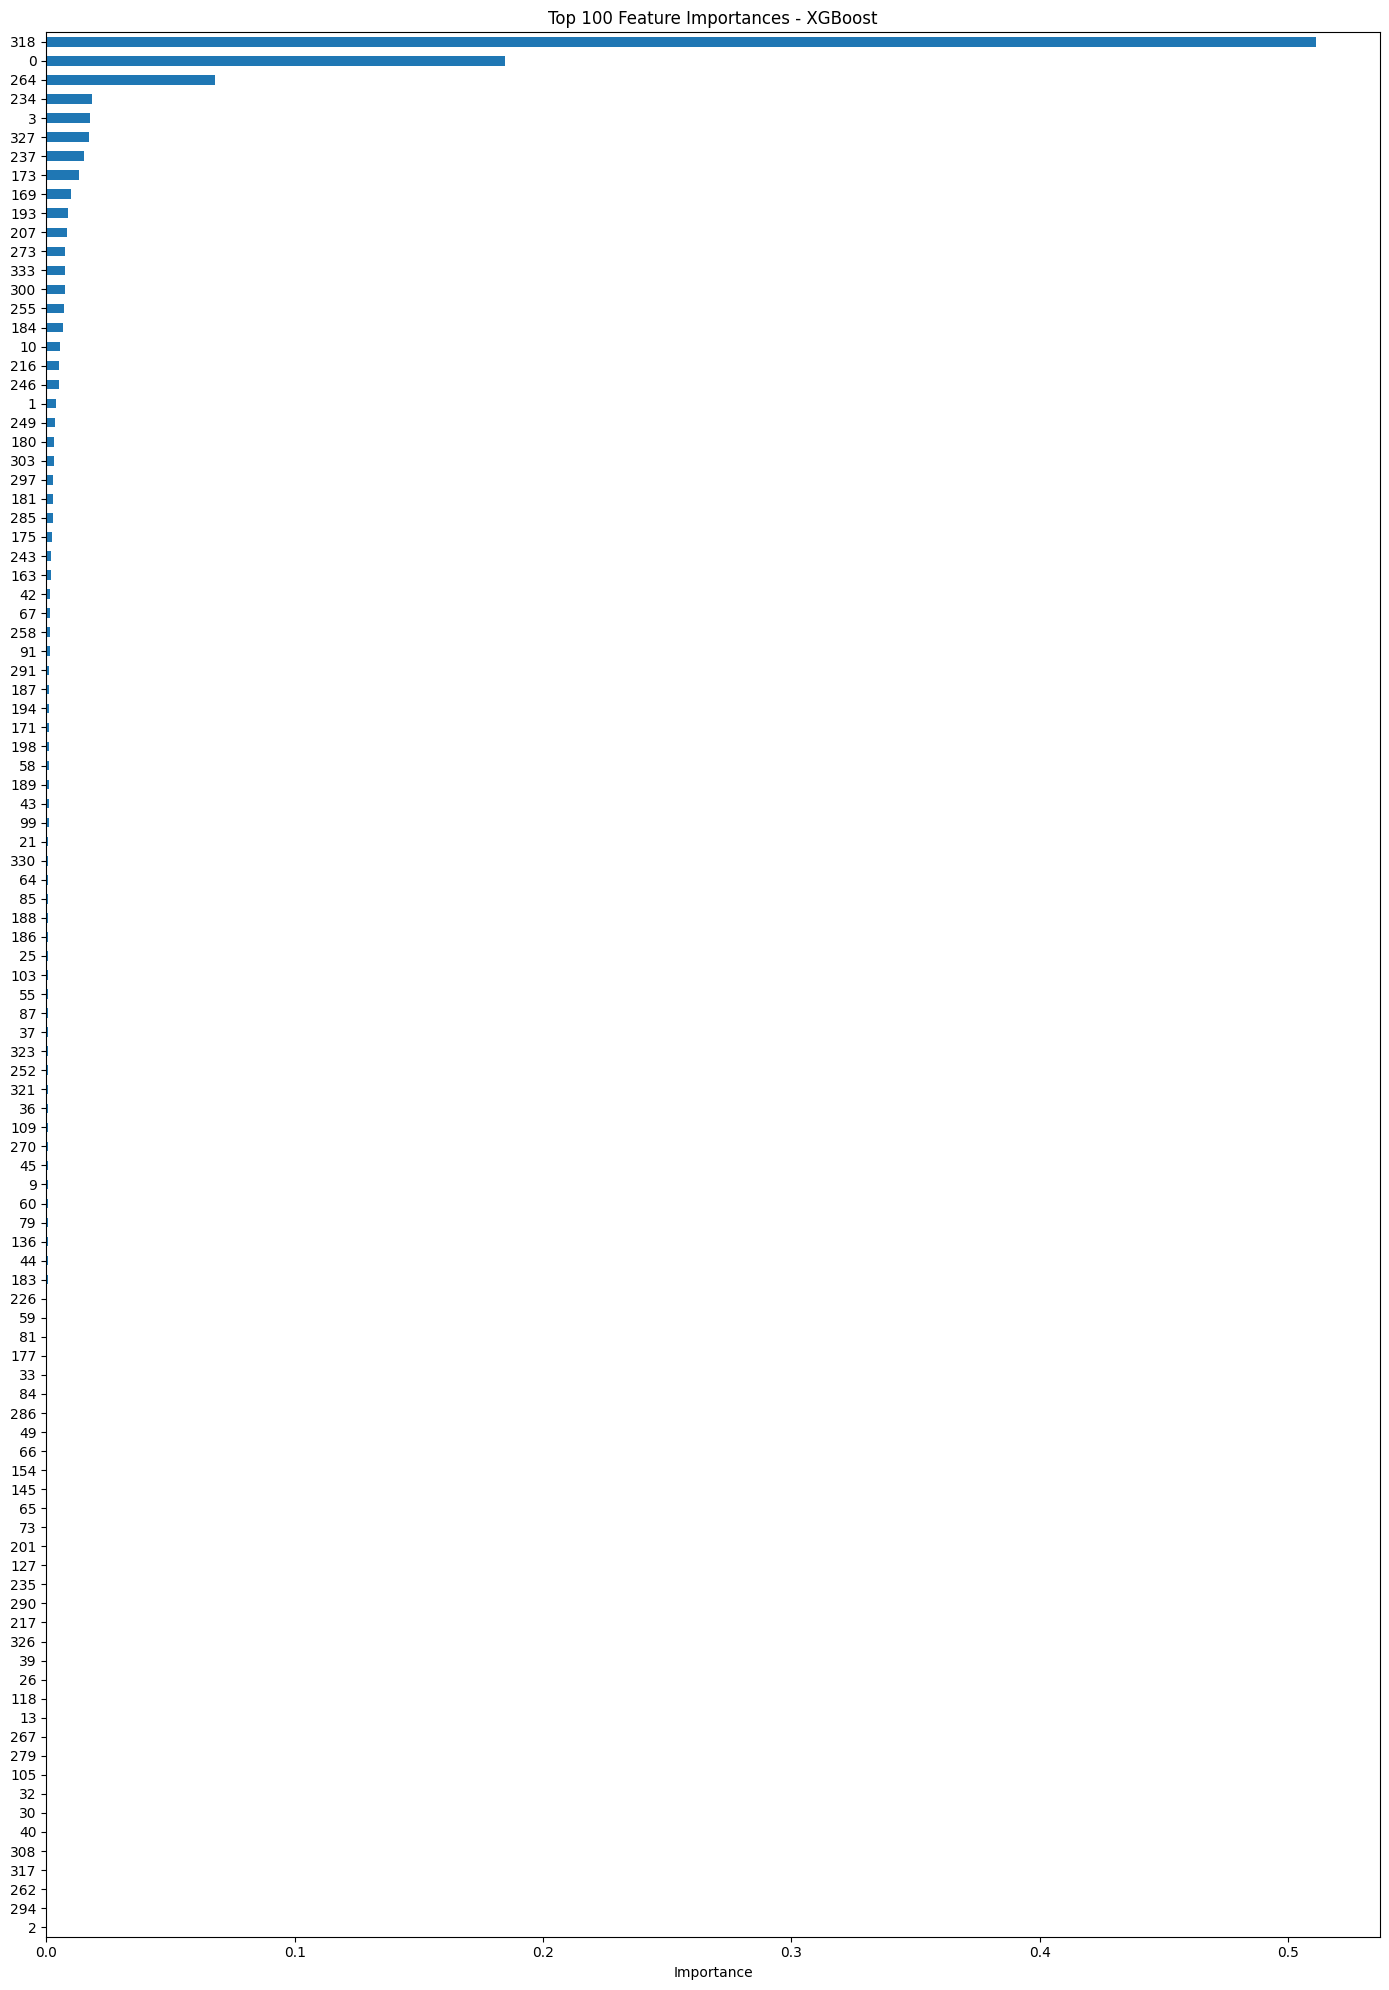

In [24]:
# Extraire les importances des features
importances = pd.Series(xgb_reg.feature_importances_)

# Trier et sélectionner les 100 meilleures
top_100 = importances.sort_values(ascending=False).head(100)

# Affichage du plot
plt.figure(figsize=(14, 20))
top_100[::-1].plot(kind='barh')  # Inverser pour avoir les + importantes en haut
plt.title("Top 100 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### 🏁 Final Model Training and Submission Generation

After validating our pipeline and model, we retrain the XGBoost model on the **entire training dataset** for final predictions. This ensures the model benefits from all available labeled data before predicting on the test set.


---


#### ✅ Steps:

1. **Fit the preprocessing pipeline** on the full training set (`X`).
2. **Train the final XGBoost model** on the fully processed data.
3. **Apply the same preprocessing** to the test set (`test_df`).
4. **Generate predictions** and create a properly formatted `submission.csv` file for Kaggle.

This ensures consistency between training and inference while maximizing model learning before final evaluation.

In [25]:
# Fit preprocessing pipeline on the full dataset
X_full_processed = preprocessor.fit_transform(X)

# Retrain XGBoost on entire data
final_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
)
final_model.fit(X_full_processed, y)

# Process test data
X_test_processed = preprocessor.transform(test_df)

# Predict
predictions = final_model.predict(X_test_processed)

# Submission file
submission = pd.DataFrame({'id': test_ids, target_column: predictions})
submission.to_csv('submission.csv', index=False)

print("✅ Submission file created successfully!")

✅ Submission file created successfully!
